## Analyse wet snow extent from SWS time series in dependence of altitude and local aspect

***
><span style = "font-family:Verdana; font-size:0.7em">Copyright © <font color='darkblue'>2022</font>, by ENVEO IT GmbH.</span>  
<span style = "font-family:Verdana; font-size:0.7em">Contributors: Gabriele Schwaizer, Lars Keuris</span>  
<span style = "font-family:Verdana; font-size:0.7em">URL: www.enveo.at</span> 
***
<p style = "font-family:Verdana; font-size:0.7em; line-height:0.5">Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files, to use the Software without restriction.</p>  
<p style = "font-family:Verdana; font-size:0.7em; line-height:1.15; text-align:justify">THE SOFTWARE IS PROVIDED AS IS, WITHOUT WARRANTY OF ANYKIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. <b>IN NO EVENT SHALL THE COPYRIGHT HOLDER BE LIABLE FOR ANY CLAIM, DIRECT INDIRECT, SPECIAL, INCIDENTAL, OR CONSEQUENTIAL DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.</b></p>

*** 

### Load python modules and packages:
***
Most of the following modules are standard Python modules (tested with Python version 3.7.11, <a href="https://github.com/python/cpython/blob/3.7/LICENSE" target="_blank">License</a>):

*Included Python Modules:*  
- os : Miscellaneous operating system interfaces
- math : Mathematical functions
- glob : Unix style pathname pattern expansion

*Included Python Packages:*
- <a href="https://gdal.org/api/python.html" target="_blank">gdal</a> (version 3.0.2)<br> 
<span style="margin-left:3%;">Tools for programming and manipulating the GDAL (Geospatial Data Abstraction Library). <b>License type:</b> MIT style <a href="https://github.com/OSGeo/gdal/blob/master/LICENSE.TXT" target="_blank">License</a></span><br>
- <a href="https://numpy.org/" target="_blank">numpy</a> (version 1.21.5)<br>
<span style="margin-left:3%;">NumPy is the fundamental package for array computing with Python. <b>License type:</b> BSD <a href="https://www.cgl.ucsf.edu/chimerax/docs/licenses/numpy-LICENSE.txt" target="_blank">License</a></span>
- <a href="https://matplotlib.org/" target="_blank">matplotlib</a> (version 3.5.1)<br>
<span style="margin-left:3%;">Python plotting package. <b>License type:</b> Python Software Foundation <a href="https://www.cgl.ucsf.edu/chimerax/docs/licenses/matplotlib-LICENSE_QT4_EDITOR.txt" target="_blank">License</a></span>
- <a href="https://pandas.pydata.org/" target="_blank">pandas</a> (version 1.3.5)<br>
<span style="margin-left:3%;">Python Data Analysis Library. <b>License type:</b> New BSD <a href="https://pandas.pydata.org/docs/getting_started/overview.html#license" target="_blank">License</a></span>
- <a href="https://github.com/python-windrose/windrose.git" target="_blank">windrose</a> (version 1.6.8)<br>
<span style="margin-left:3%;">Python library to manage wind data, draw windroses (also known as polar rose plots), and fit Weibull probability density functions.<br></span><span style="margin-left:3%;"><b>License type:</b> <a href="https://github.com/python-windrose/windrose/blob/master/LICENCE_CECILL-B.TXT" target="_blank">CECILL-B</a> and <a href="https://github.com/python-windrose/windrose/blob/master/LICENCE_BSD-3-Clause.TXT" target="_blank">BSD-3-Clause</a></span>

In [32]:
import os
import math
import glob

import gdal
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from windrose import WindroseAxes

#### Function to open and read GeoTiff files assuming that products downloaded from the catalogue are already extracted:

In [33]:
def readTif(file_tif):

    ds = gdal.Open(file_tif)
   # Projection
    proj = ds.GetProjection()
    # Dimensions
    width = ds.RasterXSize
    height = ds.RasterYSize
    # Number of bands
    count = ds.RasterCount
    # Metadata for the raster dataset
    meta = ds.GetMetadata()
    data = ds.ReadAsArray()
    ds = None
    return data, width, height, count, meta, proj

#### Function to calculate aspect from digital elevation model:

In [34]:
def aspect(z):
    """Calculate aspect from DEM."""
    x, y = np.gradient(z)
    return np.arctan2(-x, y)

### <font color='red'>Enter a valid path and file names into the following box. These are mandatory as input for all following steps:</font>
***
#### <font color='blue'>"path_input"</font>: Enter local path on your machine where products are stored. 
_Note: If you copy/paste the path from a windows explorer, add an <b>"r"</b> before the string to interpret backslashes as slashes, as shown in the example below. If your path contains already slashes, remove the <b>"r"</b> in the beginning of the string._

#### <font color='blue'> "files_wsm"</font>: Define the wet snow product file names to be loaded. 
_Note: In the template, all files starting with <b>'SWS_'</b> and ending with <b>'_WSM.tif'</b> are searched._
#### <font color='blue'> "file_elev"</font>: Define the digital elevation model file name with the same geometry as the SWS products to be used for the analysis.
_Note: In this template, the DEM file name must include <b>"DEM_60m"</b> and extension should be <b>".tif"</b>, and must be stored in the same directory as the SWS products._

In [35]:
path_input =  r"SWS"
files_wsm = glob.glob(os.path.join(path_input, "SWS_*_WSM.tif"))
file_elev = glob.glob(os.path.join(path_input, "*DEM_60m*.tif"))

#### Open and read the DEM file using the function defined in box [2]:

In [36]:
elev_data = readTif(file_elev[0])[0]

#### Calculate aspect from DEM using the function defined in box [3], and plot resulting layer:
_Note: aspect calculation in the function provides the aspect in radians. For the illustration with the windrose toolbox, aspect information must be converted to degress, scaled between 0 and 360°. So, an offset of 180° is added to the conversion formula to rescale values from range [-180, 180] to [0, 360]._

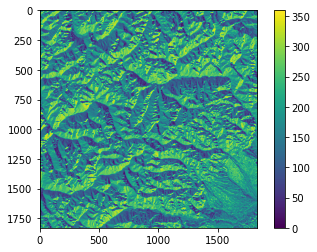

In [37]:
asp_data = aspect(elev_data)
aspdeg = (180./np.pi)*asp_data+180. # convert to degrees
plt.imshow(aspdeg)
plt.colorbar()

#### Open and read all Wet Snow products for Mountains using the function defined in box [2]:

In [38]:
wsm_datas = []
for file_wsm in files_wsm:
    wsm_datas.append(readTif(file_wsm)[0])

#### Extract aspect and elevation information for wet snow pixels and add these to a pandas data frame for each SWS product of the time series:
_Note: the maxelev, minelev and elevrange can be activated if needed to get the minimum/maximum elevation and the elevation range of the selected scene._

,elevation,aspect
0,1968,199.440035
1,2005,243.434949
2,2015,237.652557
3,2024,230.527540
4,2043,229.969741
...,...,...
290710,1782,270.734521
290711,1751,273.972496
290712,1574,310.236358
290713,1543,298.610460


,elevation,aspect
0,1746,217.303948
1,1750,84.957549
2,1749,197.744672
3,1758,90.000000
4,1749,46.847610
...,...,...
477967,2318,299.357754
477968,2280,298.810794
477969,2269,302.905243
477970,1555,295.709954


,elevation,aspect
0,1746,217.303948
1,1752,104.036243
2,1750,84.957549
3,1749,197.744672
4,1758,90.000000
...,...,...
452657,2336,215.537678
452658,2484,258.518009
452659,2541,191.888658
452660,2501,121.701430


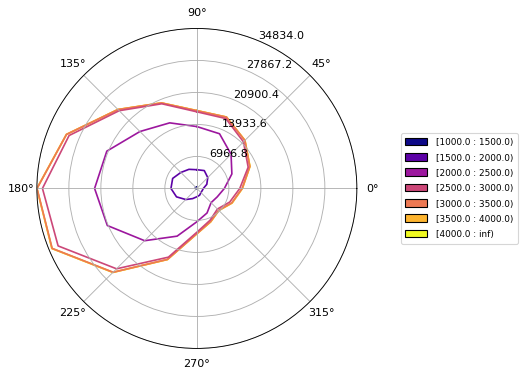

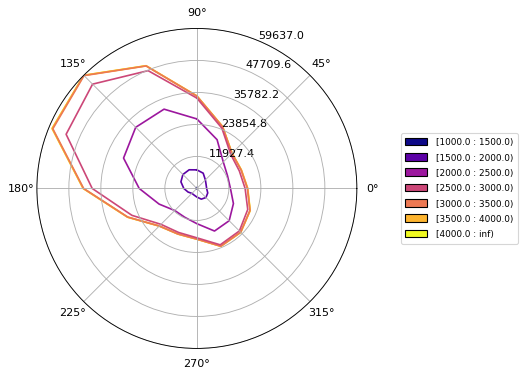

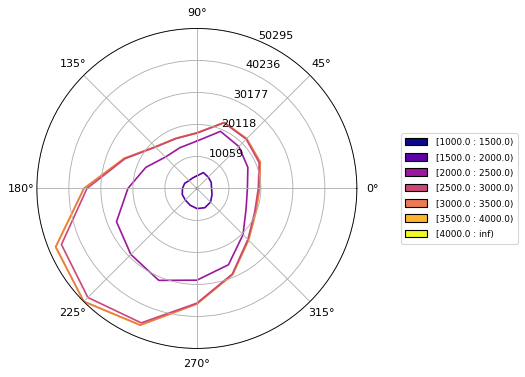

In [39]:
val_wet_snow = 110

for wsm_data in wsm_datas:
    dataframe_list = []
    
    sel = (wsm_data == val_wet_snow)
    elev_sel = elev_data[sel]
    #maxelev = int(np.max(np.round(elev_sel/100)*100))
    #minelev = math.floor(np.min(elev_sel/100))*100
    #elevrange = int(np.round((maxelev - minelev)/100)*100)
    #print(minelev, maxelev, elevrange)
    
    asp_sel = aspdeg[sel]
    
    df = pd.DataFrame({"elevation": elev_sel, "aspect": asp_sel})
    dataframe_list.append(df)
    
    ax = WindroseAxes.from_ax(rect=[0,0,0.5,0.5])
    # display datasets
    for df in dataframe_list:
        display(df)
        ax.contour(df.aspect, df.elevation, bins=np.arange(1000, 4500, 500), cmap=cm.plasma)
        ax.set_legend(loc='right', bbox_to_anchor=(1.5,0.5))